In [1]:
import numpy as np

prob = {}
prob['rov_T'] = 15
prob['cop_T'] = 30
prob['rov_x0'] = np.array([0.5, -4.5])
prob['cop_x0'] = np.array([-0.5, -4.5, 2])
prob['cop_xT'] = np.array([4.5, -4.5, 2])
prob['cop_sight'] = 2
prob['weak_accu'] = 0.85
prob['prob_margin'] = 0.1

In [2]:
import polytope as pc
from collections import OrderedDict

from best.abstraction import Abstraction
from best.mdp import ParallelMDP
import best.rss18_functions as rf

# regions
regs = OrderedDict()

regs['r1'] = (pc.box2poly(np.array([[2, 3], [0, 5]])), 0.5, 'red')
regs['r2'] = (pc.box2poly(np.array([[-3, -2], [1, 5]])), 1, 'red')
regs['r3'] = (pc.box2poly(np.array([[-5, -3], [0, 1]])), 0.5, 'red')
regs['a1'] = (pc.box2poly(np.array([[-1, 1], [4, 5]])), 0.5, 'green')
regs['b1'] = (pc.box2poly(np.array([[4, 5], [4, 5]])), 0.5, 'blue')
regs['c1'] = (pc.box2poly(np.array([[-5, -4], [4, 5]])), 0.5, 'blue')

e_init = [0 if  reg[1] in [0,1] else 2 for reg in regs.itervalues()]
env_N_list = [1 if  reg[1] in [0,1] else 5 for reg in regs.itervalues()]

prob['regs'] = regs
prob['env_x0'] = e_init


# formula
prob['formula'] = '( ( ! fail U sampleA ) & ( ! fail U sampleB ) ) | ( ! fail U ( sampleC ) )'

# rover model
rover_abstr = Abstraction([-5, -5], [5, 5], [10, 10])
rover = rover_abstr.abstract()
rover.input_name = 'ar'
rover.output_name = 'xr'
print rover

# copter model
copter_abstr = Abstraction([-5, -5, 1.5], [5, 5, 3.5], [10, 10, 2])
copter = copter_abstr.abstract()
copter.input_name = 'ac'
copter.output_name = 'xc'
print copter

# Environment belief model
env = ParallelMDP([rf.environment_belief_model(info[1], [1-prob['weak_accu'], prob['weak_accu']], name) for (name, info) in regs.iteritems()])
print env

# connect rover-env
rover_env_mdp = rover.product(env, connection=rf.get_conn_rov_env(prob['regs']) )
print rover_env_mdp

# Connect copter-env
mdp_copt_env = copter.product(env, connection=rf.get_conn_copt_env(prob['regs'], prob['cop_sight']) )
print mdp_copt_env

print 'MDP totals: {}, {}'.format(rover_env_mdp.N * 3 ,mdp_copt_env.N)

MDP: 5 inputs "ar" --> 100 outputs "xr"
MDP: 7 inputs "ac" --> 200 outputs "xc"
MDP: 243 inputs "(r1_u, r2_u, r3_u, a1_u, b1_u, c1_u)" --> 3125 outputs "(r1_b, r2_b, r3_b, a1_b, b1_b, c1_b)"
MDP: 5 inputs "ar" --> 312500 outputs "(xr, (r1_b, r2_b, r3_b, a1_b, b1_b, c1_b))"
MDP: 7 inputs "ac" --> 625000 outputs "(xc, (r1_b, r2_b, r3_b, a1_b, b1_b, c1_b))"
MDP totals: 937500, 625000


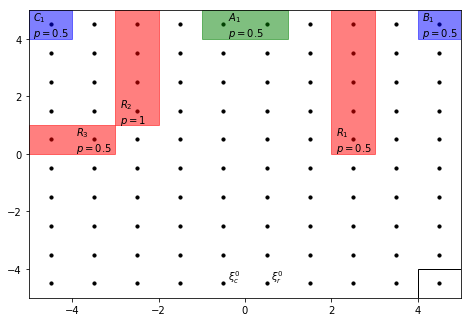

In [3]:
# plot regions

import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
fig.add_axes(ax)
rover_abstr.plot(ax)

for name, info in regs.iteritems():
    rf.plot_region(ax, info[0], name, info[1], info[2])
    
ax.text(prob['rov_x0'][0]+0.1, prob['rov_x0'][1]+0.1, '$\\xi_r^0$')

ax.add_patch(patches.Rectangle(  prob['cop_xT'][:2]-0.5, 1, 1, fill=False ))
ax.text( prob['cop_x0'][0]+0.1, prob['cop_x0'] [1]+0.1, '$\\xi_c^0$')

fig.savefig('arena.pdf')

In [4]:
# solve rover LTL problem
from best.ltl import solve_ltl_cosafe

rover_ltlpol = solve_ltl_cosafe(rover_env_mdp, prob['formula'], rf.get_ltl_connection(regs),
                                horizon=prob['rov_T'], verbose=True)

# copter problem

# set up target set
init_rov = rover_abstr.x_to_s(prob['rov_x0'])
init_dfsa = rover_ltlpol.dfsa_init
v_max = np.max(rover_ltlpol.val[0].flatten())

idx = np.logical_or(rover_ltlpol.val[0][init_rov, :, init_dfsa] > v_max-prob['prob_margin'],
                    rover_ltlpol.val[0][init_rov, :, init_dfsa] < prob['prob_margin'])

Vacc = np.zeros(mdp_copt_env.N_list)
Vacc[:, idx] = 1

end_cop = copter_abstr.x_to_s(prob['cop_xT'])

# constraint set (landing)
Vcon = np.zeros(mdp_copt_env.N_list)
Vcon[end_cop, :] = 1

val_copt_list, pol_copt_list = mdp_copt_env.solve_reach_constrained(Vacc, Vcon, 0.95, horizon=prob['cop_T'], verbose=True)

iteration 0, time 7.29560852051e-05
iteration 1, time 5.85477209091
iteration 2, time 9.57380795479
iteration 3, time 13.5716040134
iteration 4, time 17.5756809711
iteration 5, time 21.7096750736
iteration 6, time 25.9769351482
iteration 7, time 29.9931659698
iteration 8, time 33.9296431541
iteration 9, time 38.0013811588
iteration 10, time 42.2276990414
iteration 11, time 45.9904949665
iteration 12, time 49.7547130585
iteration 13, time 53.8077001572
iteration 14, time 57.8149280548
finished after 61.5317959785s and 15 iterations
iteration 0, time 9.53674316406e-07
iteration 1, time 2.68075799942
iteration 2, time 5.161703825
iteration 3, time 7.56430983543
iteration 4, time 9.89613890648
iteration 5, time 12.2602210045
iteration 6, time 14.5873949528
iteration 7, time 16.9622008801
iteration 8, time 19.6525988579
iteration 9, time 22.2209429741
iteration 10, time 24.8173520565
iteration 11, time 27.3944170475
iteration 12, time 29.9160459042
iteration 13, time 32.417858839
iteration 

In [5]:
# save controllers
copter_policy = rf.CopterPolicy(pol_copt_list, val_copt_list, copter_abstr)
rover_policy = rf.RoverPolicy(rover_ltlpol, rover_abstr)

if True:
    import cPickle as pickle
    with open('policies.pickle', 'wb') as fp:
      pickle.dump((copter_policy, rover_policy, prob), fp)

success probability: 0.25


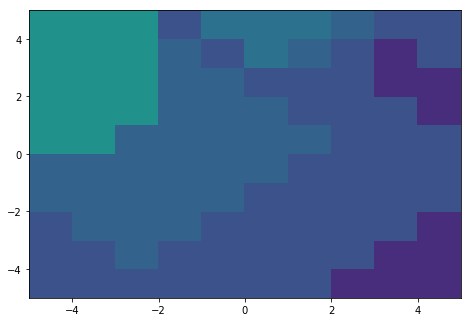

In [6]:
# plot rover value fcn
def my_value(x, mapstate):    
    s_abstr = rover_abstr.x_to_s(x)
    s_map = env.global_state(mapstate)

    _, val = rover_ltlpol((s_abstr, s_map))
    return val

def my_init_value(x, y):
    return my_value(np.array([x, y]), prob['env_x0'])

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
# ax.set_axis_off()
fig.add_axes(ax)

x, y = np.meshgrid(np.arange(-5, 6, 1), np.arange(-5, 6, 1))
xx, yy = np.meshgrid(np.arange(-5, 5, 1), np.arange(-5, 5, 1))
vals = np.vectorize(my_init_value)(xx+0.5, yy+0.5)

ax.pcolor(x, y, vals, vmin=0, vmax=1)

print 'success probability: {}'.format(my_value(prob['rov_x0'], prob['env_x0']))

fig.savefig('value-rov.pdf')

success value: 0.688906252384


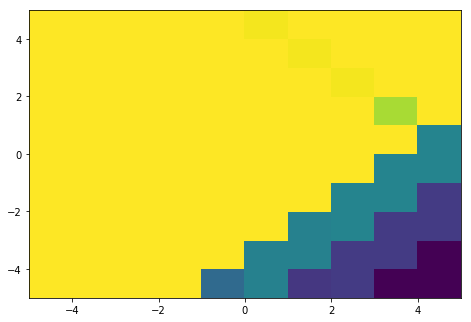

In [7]:
# plot copter value fcn
map_init = env.global_state(prob['env_x0'])

def copter_value(x, mapstate):  
    scop = copter_abstr.x_to_s(x)
    
    return val_copt_list[0][scop, mapstate]

def my_init_cvalue(x, y):
    return copter_value(np.array([x, y, 2]), map_init)

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
# ax.set_axis_off()
fig.add_axes(ax)

x, y = np.meshgrid(np.arange(-5, 6, 1), np.arange(-5, 6, 1))
xx, yy = np.meshgrid(np.arange(-5, 5, 1), np.arange(-5, 5, 1))

vals = np.vectorize(my_init_cvalue)(xx+0.5, yy+0.5)

ax.pcolor(x, y, vals)

print 'success value: {}'.format(copter_value(prob['cop_x0'], map_init))

mapstate: [0, 0, 1, 4, 4, 2]
prob of success: 1.0
mapstate: [3, 0, 0, 1, 2, 3]
prob of success: 0.850000023842
mapstate: [3, 0, 3, 3, 2, 2]
prob of success: 0.0750000029802
mapstate: [0, 0, 3, 4, 0, 2]
prob of success: 0.0750000029802


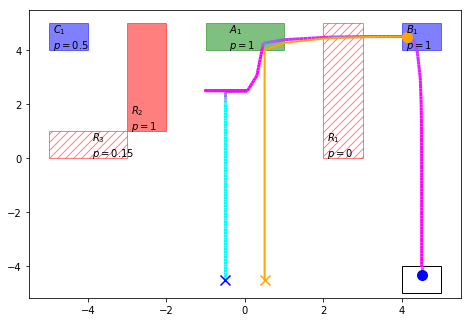

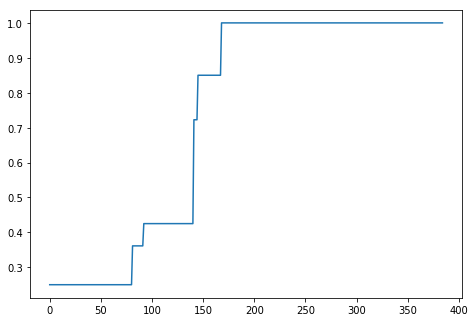

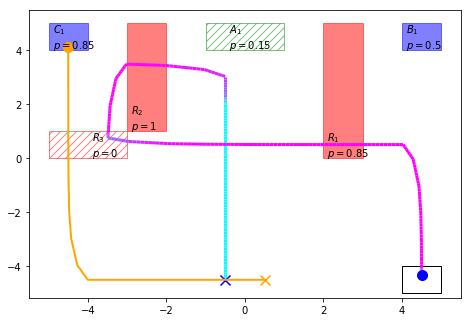

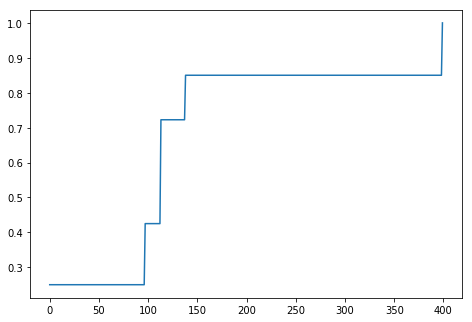

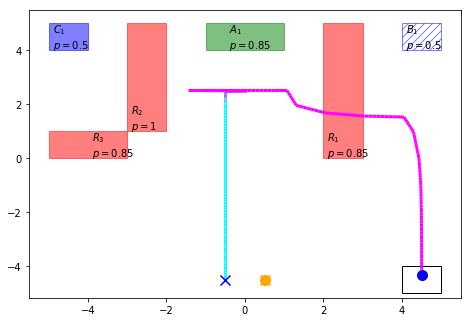

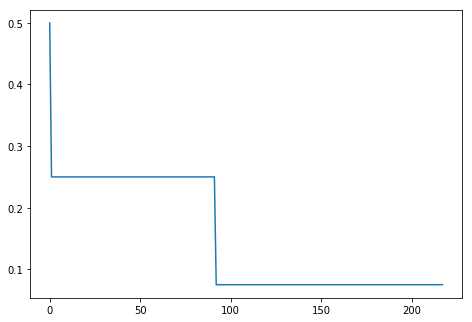

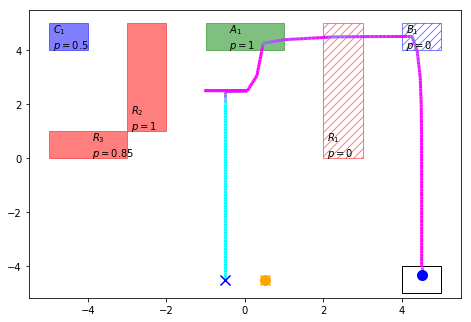

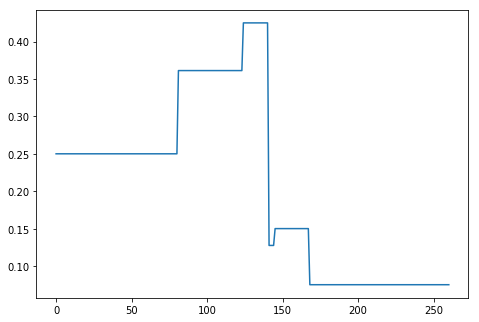

In [17]:
# Simulations
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from best import midx_to_idx

reload(rf)
copter_policy = rf.CopterPolicy(pol_copt_list, val_copt_list, copter_abstr)
rover_policy = rf.RoverPolicy(rover_ltlpol, rover_abstr)


conn_copt_env = rf.get_conn_copt_env(prob['regs'], prob['cop_sight'])
conn_rov_env = rf.get_conn_rov_env(prob['regs'])
conn_ltl = rf.get_ltl_connection(prob['regs'])

realmaps = ([0, 0, 0, 4, 4, 4], [4, 0, 0, 0, 4, 4], [4, 0, 4, 4, 0, 4], [0, 0, 4, 4, 0, 4])   # true map state

for exp_i in range(len(realmaps)):
    
    realmap = realmaps[exp_i][:]
    
    mapstate = prob['env_x0'][:]
    
    rover_policy.reset()
    copter_policy.reset()

    # copter simulation
    x_copter = prob['cop_x0'].reshape((1,3))

    val = my_value(x_rover[-1,:], mapstate)
    x_rover = prob['rov_x0'].reshape((1,2))
    
    psuccess = np.array([val])
    
    while not copter_policy.finished():

        x_curr = x_copter[-1, :].flatten()

        map_meas = list(conn_copt_env(x_curr))[0]

        for i in range(len(map_meas)):
            if mapstate[i] in [0, 4]:
                continue
            if map_meas[i] == 1:  # weak meas
                if realmap[i] == 4:
                    mapstate[i] = 3
                else:
                    mapstate[i] = 1
            if map_meas[i] == 2:
                mapstate[i] = realmap[i]
        x_map = midx_to_idx(mapstate, env_N_list)
        x_next, val = copter_policy(x_curr, x_map)

        if np.linalg.norm(x_next - x_curr) > 0:
            x_del = x_curr + 0.1*(x_next - x_curr)/np.linalg.norm(x_next - x_curr)
            x_copter = np.vstack([x_copter, x_del])
        else:
            x_copter = np.vstack([x_copter, x_curr])

        psuccess = np.hstack([psuccess, my_value(x_rover[-1,:], mapstate)])
        
    print 'mapstate: {}'.format(mapstate)
    print 'prob of success: {}'.format(my_value(prob['rov_x0'], mapstate))
    mid_probs = env.output(env.global_state(mapstate[:]))

    # rover simulation
    it = 0
    val = my_value(prob['rov_x0'], mapstate)
    
    while not rover_policy.finished() and val > 0.5:
        
        x_curr = x_rover[-1, :].flatten()
        map_meas = list(conn_rov_env(x_curr))[0]
        for i in range(len(map_meas)):
            if map_meas[i] == 2:  # strong meas
                mapstate[i] = realmap[i]
        x_map = midx_to_idx(mapstate, env_N_list)
        
        aps = conn_ltl((x_curr, env.output(x_map)))
        x_next, val = rover_policy(x_curr, x_map, list(aps)[0])

        if np.linalg.norm(x_next - x_curr) > 0:
            x_del = x_curr + 0.1*(x_next - x_curr)/np.linalg.norm(x_next - x_curr)
        else:
            x_del = x_curr
        x_rover = np.vstack([x_rover, x_del])
        
        psuccess = np.hstack([psuccess, my_value(x_rover[-1,:], mapstate)])

    fig = plt.figure()
    ax = plt.Axes(fig, [0.,0.,1.,1.])
    fig.add_axes(ax)
    
    i = 0
    for (name, info) in prob['regs'].iteritems():
        if realmap[i] == 0 and info[1] != 1:
            hatch = '///'
            fill = False
        else:
            hatch = False
            fill = True
        rf.plot_region(ax, info[0], name, '{}'.format(mid_probs[i]), info[2], hatch=hatch, fill=fill)
        i += 1
        
    points = np.array([x_copter[:,0], x_copter[:,1]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=plt.get_cmap('cool'))
    lc.set_array(x_copter[:, 2])
    lc.set_linewidth(3)
    ax.add_collection(lc)
    
    ax.scatter(x_copter[0, 0], x_copter[0, 1], marker='x', color='blue', zorder=2, s=100)
    ax.scatter(x_copter[-1, 0], x_copter[-1, 1], marker='o', color='blue', zorder=2, s=100)

    ax.plot(x_rover[:, 0], x_rover[:, 1], color='orange', linewidth=2)
    ax.scatter(x_rover[0, 0], x_rover[0, 1], marker='x', color='orange', zorder=2, s=100)
    ax.scatter(x_rover[-1, 0], x_rover[-1, 1], marker='o', color='orange', zorder=2, s=100)

    ax.add_patch(patches.Rectangle( prob['cop_xT'][:2]-0.5, 1, 1, fill=False ))

    fig.savefig('exp2-{}-map.pdf'.format(exp_i))

    fig = plt.figure()
    ax = plt.Axes(fig, [0.,0.,1.,1.])
    fig.add_axes(ax)
    ax.plot(psuccess)
    
    np.savetxt('exp2-{}-proba.txt'.format(exp_i),  np.vstack([psuccess, np.arange(len(psuccess))]).T, delimiter=' ')